# Exercise C4

In this notebook excersice, you should implement two variations of the Monte Carlo learning algorithm that was presented in the lecture. 

### README
We recommend you install `gymnasium>=0.28.1` and `python>=3.10.*`. You can set up a python environment using e.g. [conda](https://docs.conda.io/projects/miniconda/en/latest/) in the terminal
```
conda create -n rl23 python=3.10 gymnasium=0.28.1 notebook -c conda-forge
conda activate rl23
```
The `notebook` package is required for opening and working with this jupyter notebook.
In a terminal with the Python environment active, run
```
jupyter notebook sysadmin.ipynb
```

If you need help setting up a development environment, please visit the office hour or ask for help in the forum.

In [41]:
packages_to_install = {
    "gymnasium": "-c conda-forge gymnasium=0.28.1",
    "numpy": "numpy=1.24.0",
    "matplotlib": "matplotlib",
    "scikit-learn": "-c conda-forge scikit-learn",
    "scipy": "-c conda-forge scipy"
}

In [42]:
%%time
import importlib

for package_name, install_command in packages_to_install.items():
    try:
        importlib.import_module(package_name)
        print(f"{package_name} is already installed.")
    except ImportError:
        print(f"{package_name} is not installed. Installing it now...")
        !conda install -y {install_command}

gymnasium is already installed.
numpy is already installed.
matplotlib is already installed.
scikit-learn is not installed. Installing it now...
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.11.0



# All requested packages already installed.

scipy is already installed.
CPU times: user 175 ms, sys: 60.9 ms, total: 236 ms
Wall time: 16.7 s


### Setup

We consider the same learning problem, i.e. the Frozen Lake example. Hence, we create the environment and add the same helpful visualization methods as used in the lecture. 

In [43]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

 
# Create the env which represents an MDP
env = gym.make("FrozenLake-v1",is_slippery=False)

In [44]:
# some useful stuff
def plot_policy(policy):
    """Plot the policy in a grid with arrows."""
    policy_square = np.array(policy).reshape(env.unwrapped.desc.shape)
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(np.ones_like(policy_square)*255, cmap='Greys', interpolation='none')
    
    for (i, j), action in np.ndenumerate(policy_square):
        if env.unwrapped.desc[i, j] == b'H':
            ax.text(j, i, 'H', ha='center', va='center', fontsize=12, color='black')
        elif env.unwrapped.desc[i, j] == b'G':
            ax.text(j, i, 'G', ha='center', va='center', fontsize=12, color='green')
        else:  # This will include both 'S' and 'F' tiles.
            if action == 0:  # left
                ax.arrow(j, i, -0.3, 0, head_width=0.2, head_length=0.2, fc='r', ec='r')
            elif action == 1:  # down
                ax.arrow(j, i, 0, 0.3, head_width=0.2, head_length=0.2, fc='r', ec='r')
            elif action == 2:  # right
                ax.arrow(j, i, 0.3, 0, head_width=0.2, head_length=0.2, fc='r', ec='r')
            elif action == 3:  # up
                ax.arrow(j, i, 0, -0.3, head_width=0.2, head_length=0.2, fc='r', ec='r')

    plt.xticks([]), plt.yticks([])
    plt.title('Policy')
    plt.show()
    
    
def ActionToDirection(action):
    if action == 0:
        return "left"
    if action == 1:
        return "down"
    if action == 2:
        return "right"
    if action == 3:
        return "up"
    return "unknown"

## Monte Carlo Control Algorithm from the Lecture

In the following, there for recap again the commented code of the final Monte Carlo Control algorithm from lecture.

Policy after iteration: 0
Got reward 1 times.


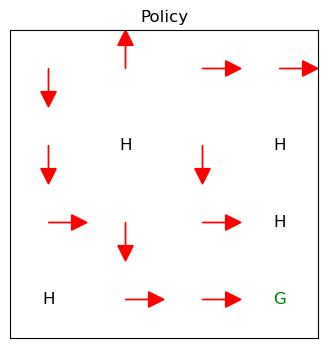

Policy after iteration: 5
Got reward 78 times.


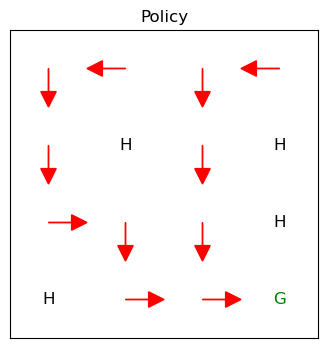

Policy after iteration: 10
Got reward 80 times.


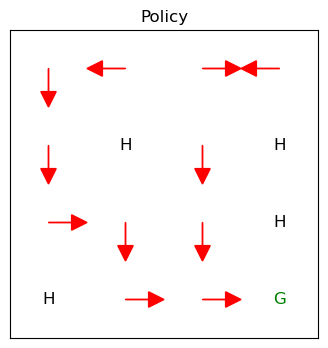

Policy after iteration: 15
Got reward 80 times.


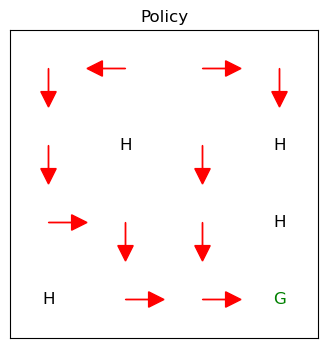

Policy after iteration: 20
Got reward 80 times.


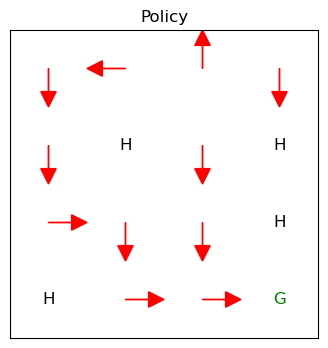

Policy after iteration: 25
Got reward 79 times.


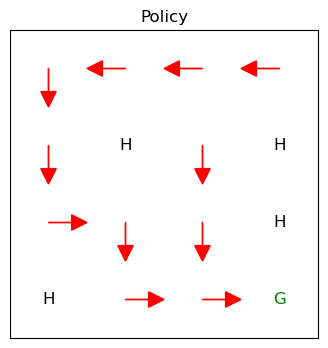

Policy after iteration: 30
Got reward 84 times.


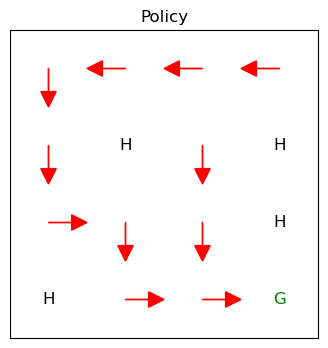

Policy after iteration: 35
Got reward 76 times.


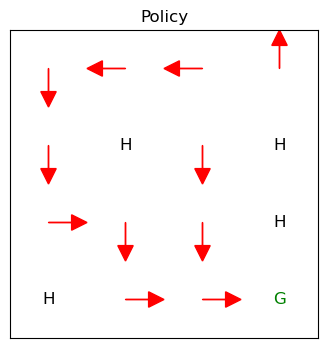

Policy after iteration: 40
Got reward 74 times.


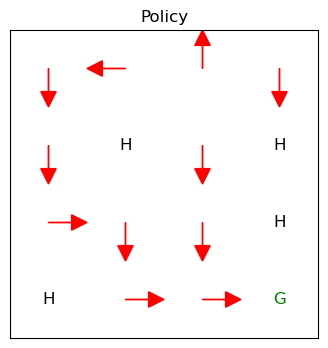

Policy after iteration: 45
Got reward 73 times.


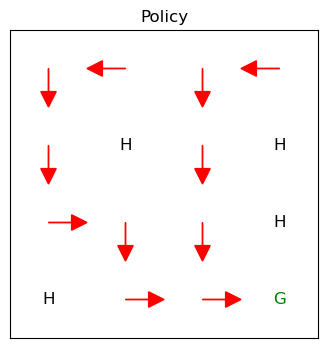

In [45]:
num_states = env.observation_space.n
num_actions = env.action_space.n

# Hyperparameters -> need some tuning
gamma = 0.9
num_iterations = 50 # evaluation-improvement iterations
num_episodes = 100 # number of episodes used to estimate the Q-values

# initialize epsilon to choose action randomly with P(epsilon) during episode generation
epsilon = 0.2

# Initialize a random policy
policy = np.random.randint(num_actions, size=num_states)
#plot_policy(policy)
###########################################################################
################### initialize Q outside the loop! ###################
# array for storing Q-values
Q = np.zeros([num_states, num_actions])


# iterate over policy evaluation and improvement
for iteration in range(num_iterations):
    
    ####### policy evaluation ###################
    episode_count = 0
    steps = 0
    count_got_reward = 0 # count how often goal was reached       
    
    # Initialize cumulative returns and counts outside the episode loop
    returns = {}  # Cumulative returns for each state-action pair across episodes
    count = {}        # Visit counts for each state-action pair
    
    # Policy Evaluation: Estimate Q-values under the current policy
    while episode_count < num_episodes:
        state, _ = env.reset()
        episode = [] # initialize empty episode        
        got_reward = False # variable to check whether we reached the goal in the current episode
        truncated = False
        done = False
        # generate an episode
        while not (truncated or done):  # ensure that episode doesn't run forever because of loops
            steps += 1 # counter for episode length
            
            ####################### Epsilon-greedy policy ##################################
            if np.random.uniform(0, 1) < epsilon:  
                action = env.action_space.sample()
            else:
                action = policy[state]  # Use the current policy             
            
            new_state, reward, done, truncated, _ = env.step(action) # transition to next state
            if reward > 0:
                got_reward = True # episode reached the goal
             
            # store episode
            episode.append((state, action, reward))
            state = new_state
                      
                
        # did this episode reach the goal?
        if got_reward:
            count_got_reward += 1
        episode_count += 1  # Increment the episode counter
        

        # compute the cumulative rewards and sort them according to their start (s,a)
        acc_return = 0
        visited_pairs = set() # track visited state-action pairs in this episode

        for t in reversed(range(len(episode))):
            s, a, r = episode[t]
            
            # check if we've seen this state-action pair before in this episode
            if (s, a) not in visited_pairs:
                visited_pairs.add((s, a)) # <-- mark the state-action pair as visited

                # calculate the sum of discounted rewards from timestep t until the end of the episode (sum runs backward)           
                acc_return = r + gamma * acc_return 

                # initialize pair if not yet visited in all episodes of this iteration
                if (s, a) not in returns:
                    returns[(s, a)] = 0
                    count[(s, a)] = 0

                # in the case of several visits, store sum
                returns[(s, a)] += acc_return 
                count[(s, a)] += 1
    
    # cumulative_returns contains now the returns from s,a for all visits on all episodes
    # Update Q-values after each episode
    for (s, a), total_return in returns.items():
        # Calculate average return for state-action pair across all episodes it's been visited
        ###########################################################################
        ############### do an inremental update here! ###############################
        Q[s, a] = Q[s, a]+ 1 / count[(s, a)]*(total_return - Q[s, a])
     
    ####### policy improvement ###################
    for state in range(num_states):
        # replace  policy[state] = np.argmax(Q[state, :]) by
        best_actions = np.argwhere(Q[state] == np.amax(Q[state])).flatten()
        policy[state] = np.random.choice(best_actions)
        
    # plot the policy after after every fifth iteration
    if (iteration % 5 == 0):
        print(f"Policy after iteration: {iteration}")
        print(f"Got reward {count_got_reward} times.")
        plot_policy(policy)

## Exercise C4 (a) (1 Point)

Implement a variation of Monte Carlo Control that uses a linear decay schedule for $\epsilon$. 

More concretely, we assume three hyperparameters to be given: 
- $\epsilon_{\text{start}}$, the start value for $\epsilon$,
- $d$, the value by which $\epsilon$ is decreased after each policy update (decay step size), 
i.e. $$\epsilon \leftarrow \epsilon - d$$ after each policy update, and
- $\epsilon_{\text{min}}$, the minimal value that $\epsilon$ should not fell below, i.e. $\epsilon \geq \epsilon_{\text{min}}$ should always hold.

Extend the Monte Carlo algorithm below with this decay schedule for $\epsilon$ and add explanatory comments at all points of the code that you adapt.

(The algorithm given below is except for the already given initialization of the hyperparameters identical to the Monte Carlo Control algorithm from above.) 

Policy after iteration: 0
Got reward 1 times.


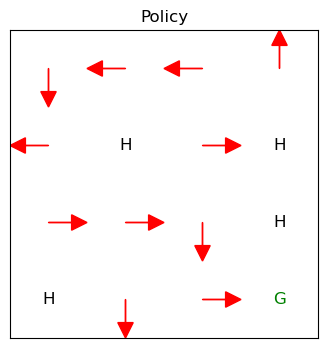

Policy after iteration: 5
Got reward 87 times.


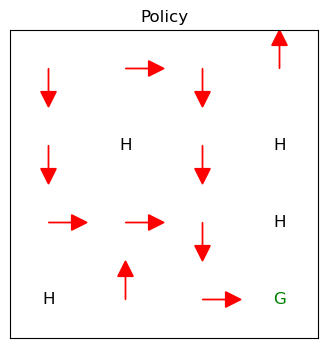

Policy after iteration: 10
Got reward 91 times.


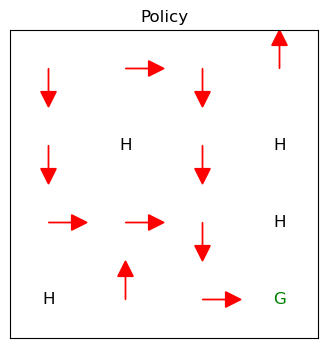

Policy after iteration: 15
Got reward 88 times.


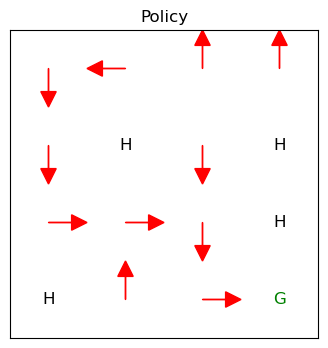

Policy after iteration: 20
Got reward 88 times.


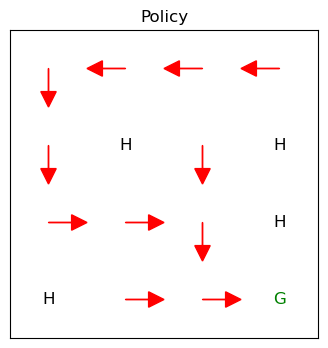

Policy after iteration: 25
Got reward 90 times.


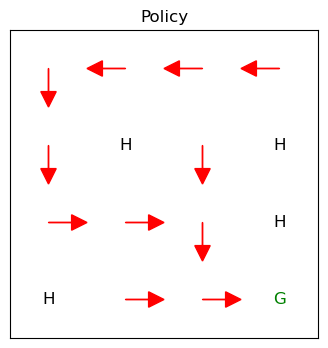

Policy after iteration: 30
Got reward 87 times.


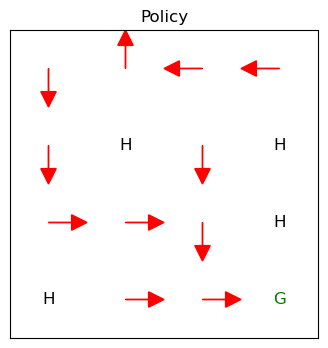

Policy after iteration: 35
Got reward 88 times.


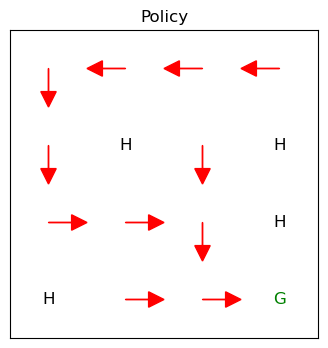

Policy after iteration: 40
Got reward 90 times.


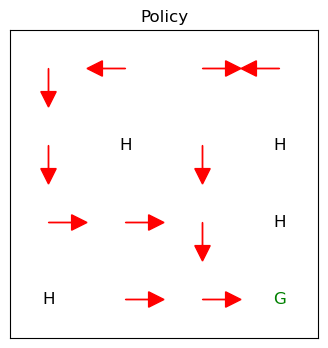

Policy after iteration: 45
Got reward 85 times.


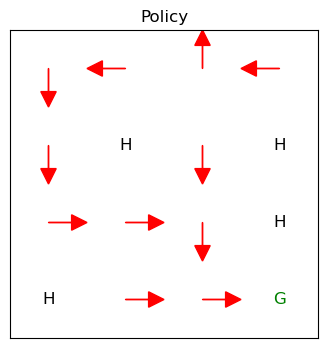

In [46]:
num_states = env.observation_space.n
num_actions = env.action_space.n

gamma = 0.9
num_iterations = 50 
num_episodes = 100 

# Hyperparameter for the decay schedule: 
epsilon_max = 0.5
d = 0.01
epsilon_min = 0.1

policy = np.random.randint(num_actions, size=num_states)

Q = np.zeros([num_states, num_actions])

for iteration in range(num_iterations):
    
    episode_count = 0
    steps = 0
    count_got_reward = 0     

    returns = {}  
    count = {}        
    
    while episode_count < num_episodes:
        state, _ = env.reset()
        episode = []       
        got_reward = False 
        truncated = False
        done = False

        while not (truncated or done):  
            steps += 1 
            
            if np.random.uniform(0, 1) < epsilon:  
                action = env.action_space.sample()
            else:
                action = policy[state]            
            
            new_state, reward, done, truncated, _ = env.step(action)
            if reward > 0:
                got_reward = True 
             
            episode.append((state, action, reward))
            state = new_state
                      
                
        if got_reward:
            count_got_reward += 1
        episode_count += 1  
        
        acc_return = 0
        visited_pairs = set() 

        for t in reversed(range(len(episode))):
            s, a, r = episode[t]
            
            if (s, a) not in visited_pairs:
                visited_pairs.add((s, a)) 
                acc_return = r + gamma * acc_return 

                if (s, a) not in returns:
                    returns[(s, a)] = 0
                    count[(s, a)] = 0

                returns[(s, a)] += acc_return 
                count[(s, a)] += 1
    
    for (s, a), total_return in returns.items():
        Q[s, a] = Q[s, a]+ 1 / count[(s, a)]*(total_return - Q[s, a])
     
    for state in range(num_states):
        best_actions = np.argwhere(Q[state] == np.amax(Q[state])).flatten()
        policy[state] = np.random.choice(best_actions)
        
    if (iteration % 5 == 0):
        print(f"Policy after iteration: {iteration}")
        print(f"Got reward {count_got_reward} times.")
        plot_policy(policy)
    
    # Only if epsilon is larger than epsilon_min then update epsilon
    if epsilon >= epsilon_min:
        epsilon = epsilon - d


## Exercise C4 (b) (2 Points)

Implement a variation of Monte Carlo Control that is extended with a convergency check. 

More concretely, we assume a hyperparameter $\delta > 0$ to be given. If the maximum change in the action value function for all state-action pair in an iteration is less than $\delta$, then the algorithm should immediately terminate.

Extend the Monte Carlo algorithm below with this convergency check and add again explanatory comments at all points of the code that you adapt.

Policy after iteration: 0
Got reward 0 times.


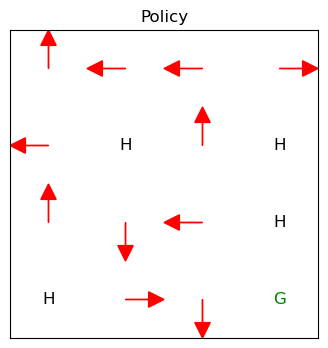

max_change:0.0
0.0 < 0.5:True
Converged after 1 iterations.


In [47]:
num_states = env.observation_space.n
num_actions = env.action_space.n

gamma = 0.9
num_iterations = 300
num_episodes = 100 

epsilon = 0.05

# Hyperparameter for the convergence check: 
delta = 0.5

policy = np.random.randint(num_actions, size=num_states)

Q = np.zeros([num_states, num_actions])
prev_Q = Q.copy()

for iteration in range(num_iterations):
    
    episode_count = 0
    steps = 0
    count_got_reward = 0     

    returns = {}  
    count = {}        
    
    while episode_count < num_episodes:
        state, _ = env.reset()
        episode = []       
        got_reward = False 
        truncated = False
        done = False

        while not (truncated or done):
            steps += 1 
            
            if np.random.uniform(0, 1) < epsilon:  
                action = env.action_space.sample()
            else:
                action = policy[state]            
            
            new_state, reward, done, truncated, _ = env.step(action)
            if reward > 0:
                got_reward = True 
             
            episode.append((state, action, reward))
            state = new_state
                      
                
        if got_reward:
            count_got_reward += 1
        episode_count += 1  
        
        acc_return = 0
        visited_pairs = set() 

        for t in reversed(range(len(episode))):
            s, a, r = episode[t]
            
            if (s, a) not in visited_pairs:
                visited_pairs.add((s, a)) 
                acc_return = r + gamma * acc_return 

                if (s, a) not in returns:
                    returns[(s, a)] = 0
                    count[(s, a)] = 0

                returns[(s, a)] += acc_return 
                count[(s, a)] += 1
                
    for (s, a), total_return in returns.items():
        Q[s, a] = Q[s, a]+ 1 / count[(s, a)]*(total_return - Q[s, a])

    for state in range(num_states):
        best_actions = np.argwhere(Q[state] == np.amax(Q[state])).flatten()
        policy[state] = np.random.choice(best_actions)

    # Check for convergence
    # Warning - algorithm seems to be stochastic so there's high probability it will converge after 1 iteration because max change of Q was 0. Hence, try multiple times.
    if iteration > 0:
        max_change = np.max(np.abs(Q - prev_Q))
        # Removing these print statements seems increase probability of converging after 1 iteration.
        print(f"max_change:{max_change}")
        print(f"{max_change} < {delta}:{max_change < delta}")
        if max_change < delta:
            print(f"Converged after {iteration} iterations.")
            break
    prev_Q = Q.copy()
        
    if (iteration % 5 == 0):
        print(f"Policy after iteration: {iteration}")
        print(f"Got reward {count_got_reward} times.")
        plot_policy(policy)

## Exercise C4 (c) (1 Point)

The above algorithm (Monte Carlo Control with convergence check) terminates sometimes already after the first iteration. What is the reason for this behavior? 

Answer:

Algorithm is stochastic. There is variance since we introduce randomness in 3 different places:

1. When we initialize policy
2. When we decide on action (np.random.uniform(0, 1))
3. When we update policy with random choice among best actions.

All these leads to maximum change in the action value function to be 0 sometimes.
Since 0 <= $\delta$, algorithm stops after first iteration.